### This notebook includes tasks 

**(1)** Display x-z coordinates on grids and use function “contourf” and “quiver” to visualize the distribution of horizontal velocities and vertical velocities as well as the vector flow field in upwelling system.  
**(2)** Track passive particles using Lagrangian model on x-z coordinates 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import xarray as xr

# Set global font sizes for all plots, now all subsequent plots will follow these settings
plt.rcParams.update({
    'axes.labelsize': 14,          # Labels font size
    'xtick.labelsize': 12,         # X-axis ticks font size
    'ytick.labelsize': 12,         # Y-axis ticks font size
    'axes.labelweight': 'bold',    # Bold axis labels
    'xtick.direction': 'out',       # X-axis tick direction
    'ytick.direction': 'out',       # Y-axis tick direction
    'font.size': 12,               # Default font size for other text
})

fig_dir = "E:\OneDrive\EcoSysModel\plot" # dir to save plots
out_dir = "E:\OneDrive\EcoSysModel\data"

### 1.	Consider a continental shelf system with a cross-shelf dimension (L) of 100 km and a depth (D) of 50 m. 
* contour the horizontal and vertical components of the flow
* plot the vector flow field

In [2]:
# Define constants
L = 100e3  # in meters, cross-shelf distance
D = 50     # 50 m, vertical depth
U0 = 50/100    # 50 cm/s converted to m/s
z0 = 0

# Define grid
x = np.linspace(0, L, 50)  # 50 points in x-direction
z = np.linspace(-D, 0, 50) # 50 points in z-direction
X, Z = np.meshgrid(x, z)   # Create meshgrid

# Compute velocity components
u = U0 * np.sin(np.pi * X / (2 * L)) * np.cos(np.pi * (Z + z0) / D)  # horizontal velocity
w = - (D / (2 * L)) * U0 * np.cos(np.pi * X / (2 * L)) * np.sin(np.pi * (Z + z0) / D) # vertical velocity

fs = 16  # fontsize

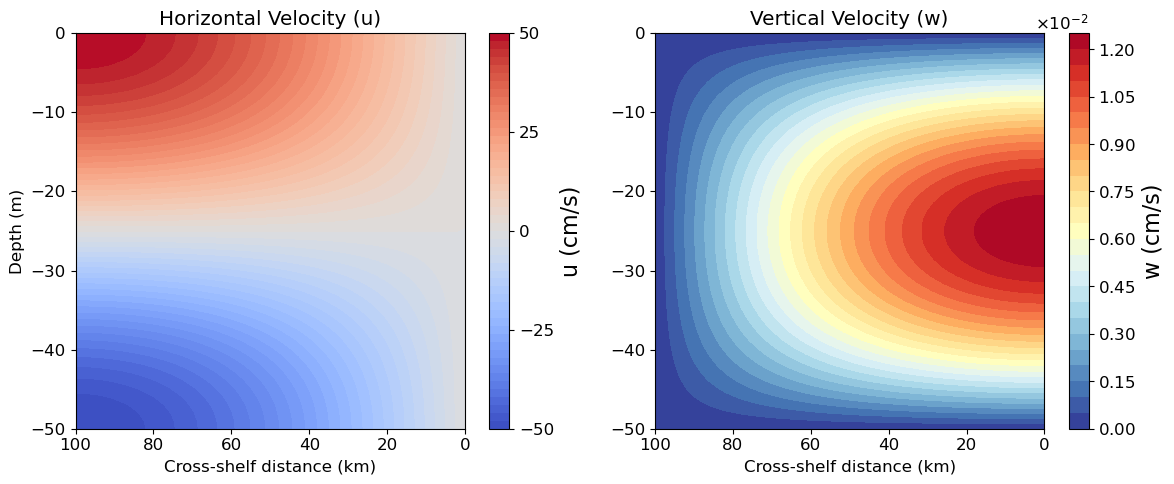

In [3]:
# Create contour plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Contour plot for u (horizontal velocity)
c1 = axes[0].contourf(X / 1e3, Z, u*1e2, cmap='coolwarm', vmin = -50, vmax = 50 ,levels=50)
axes[0].set_title("Horizontal Velocity (u)")
axes[0].set_xlabel("Cross-shelf distance (km)")
axes[0].set_ylabel("Depth (m)")
axes[0].invert_xaxis()  # Reverse x-axis, assume it's west coast
cbar1 = fig.colorbar(c1, ax=axes[0])
cbar1.set_ticks([-50, -25, 0, 25, 50])  # Set specific tick locations
cbar1.set_label("u (cm/s)", fontsize=fs)

# Contour plot for w (vertical velocity)
c2 = axes[1].contourf(X / 1e3, Z, w*1e2, cmap='RdYlBu_r', levels=25)
axes[1].set_title("Vertical Velocity (w)")
axes[1].set_xlabel("Cross-shelf distance (km)")
axes[1].invert_xaxis()  # Reverse x-axis, assume it's west coast
cbar2 = fig.colorbar(c2, ax=axes[1])
cbar2.formatter = ScalarFormatter(useMathText=True)
cbar2.formatter.set_powerlimits((-2, 0))
cbar2.set_label("w (cm/s)", fontsize=fs)
plt.tight_layout()
plt.savefig(f'{fig_dir}/cross_shelf_flow.png', bbox_inches='tight', dpi = 300)
plt.show()

**The flow structure is like wind-driven upwelling/downwelling circulation on a continental shelf, where surface Ekman transport can lead todivergence (offshore flow) and upwelling, while bottom return flows balance the system.**

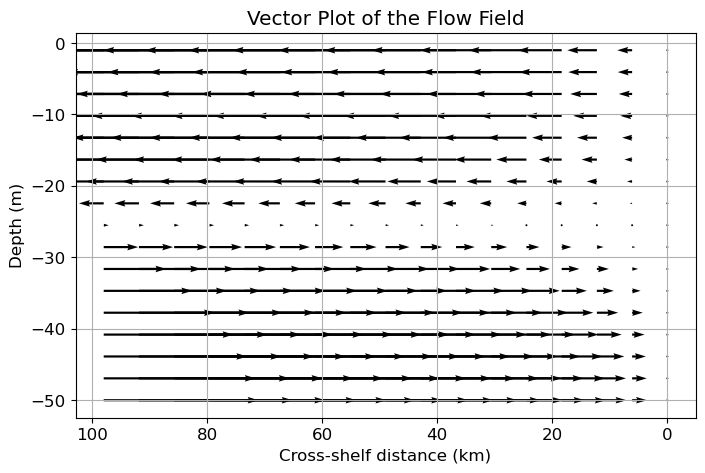

In [4]:
# Vector plot of the velocity field
plt.figure(figsize=(8, 5))
skip = (slice(None, None, 3), slice(None, None, 3))  # Reduce layers for clarity
plt.quiver(X[skip] / 1e3, Z[skip], 1e2*u[skip], 1e2*w[skip], angles='xy', scale=200, color='black')
plt.xlabel("Cross-shelf distance (km)")
plt.ylabel("Depth (m)")
plt.title("Vector Plot of the Flow Field")
plt.gca().invert_xaxis()  # Reverse x-axis, assume it's west coast
plt.grid(True)
plt.savefig(f'{fig_dir}/cross_shelf_vector_flow.png', bbox_inches='tight', dpi = 300)
plt.show()


### 2. Lagrangian Model—Track Passive Particles


In [5]:
# Define input parameters
nx, nz = 11, 11  # nx and nz are horizontal and vertical increments
tdepth = D *100  # total depth in centimeters (cm)
tlength = L *1e2 # total length in centimeters (cm)
xmin, xmax = 0.0, tlength # set horizontal model dimension in centimeters (cm)
zmin, zmax = 0.0, tdepth  # set vertical model dimension in centimeters (cm)

# Set velocity field constants
u0 = 50.0  # u0 is initial velocity amplitude in cm/s 
z0 =0
pi = np.pi
wcons = tdepth / (2.0 * tlength) # it is a ratio in vertical component equation that sets the depth of the upwelling cell

# Define arrays
uvel = np.zeros((nx, nz))  # Horizontal velocity
wvel = np.zeros((nx, nz))  # Vertical velocity

xlocation = np.linspace(0, xmax, nx)
zlocation = np.linspace(0, zmax, nz)

In [6]:
# Calculate velocity field
for i in range(nx):
    for j in range(nz):
        # print(i,j)
        ua = np.sin(np.pi * xlocation[i] / (2 * tlength))   
        ub = np.cos(np.pi * (zlocation[j] + z0) / tdepth)   # z0 is zero
        uvel[j, i] = u0 * ua * ub 

        wa = np.cos(np.pi * xlocation[i] / (2 * tlength))   
        wb = np.sin(np.pi * (zlocation[j] + z0) / tdepth)  # z0 is zero
        wvel[j, i] = wcons * u0 * wa * wb     # remove minus sign, since zlocation are positive values
        
# Convert x and z locations to km and m
xlocation *= 1e-5  # Convert cm to km
zlocation *= 0.01  # Convert cm to m

#### 2.1 Plot the flow field

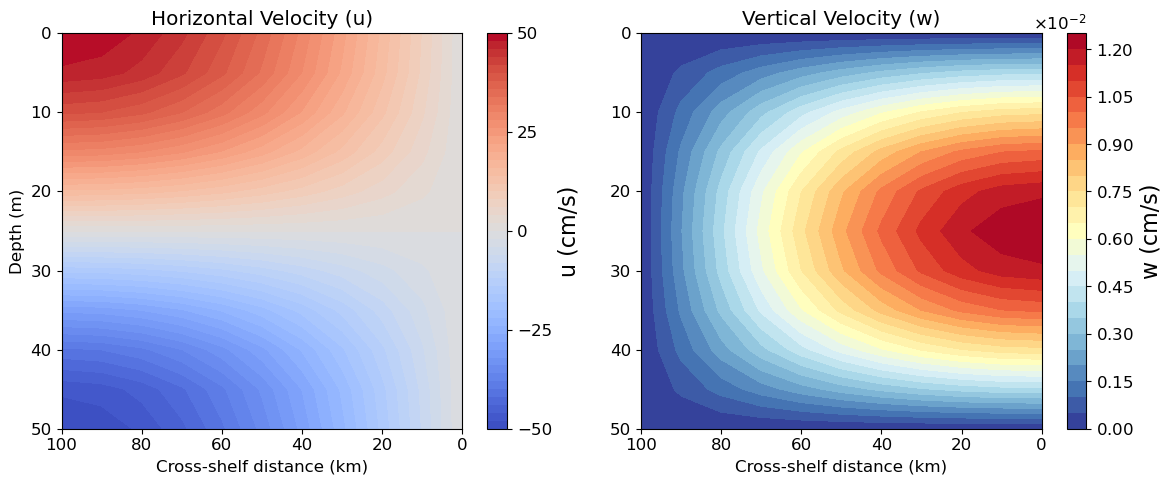

In [7]:
X, Z = np.meshgrid(xlocation, zlocation)   # Create meshgrid


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Contour plot for u (horizontal velocity)
c1 = axes[0].contourf(X, Z, uvel, cmap='coolwarm', vmin = -50, vmax =50 ,levels=50)
axes[0].set_title("Horizontal Velocity (u)")
axes[0].set_xlabel("Cross-shelf distance (km)")
axes[0].set_ylabel("Depth (m)")
axes[0].set_xlim([xlocation[0], xlocation[-1]])
axes[0].invert_yaxis()
axes[0].invert_xaxis()  # Reverse x-axis, assume it's west coast
cbar1 = fig.colorbar(c1, ax=axes[0])
cbar1.set_ticks([-50, -25, 0, 25, 50])  # Set specific tick locations
cbar1.set_label("u (cm/s)", fontsize=fs)


# Contour plot for w (vertical velocity)
c2 = axes[1].contourf(X, Z, wvel, cmap='RdYlBu_r', levels=25)
axes[1].set_title("Vertical Velocity (w)")
axes[1].set_xlabel("Cross-shelf distance (km)")
axes[1].invert_yaxis()
axes[1].invert_xaxis()  # Reverse x-axis, assume it's west coast
cbar2 = fig.colorbar(c2, ax=axes[1])
cbar2.formatter = ScalarFormatter(useMathText=True)
cbar2.formatter.set_powerlimits((-2, 0))
cbar2.set_label("w (cm/s)", fontsize=fs)
plt.tight_layout()

plt.show()

#### 2.2 Release one particle at 40 km and 45 m, track the particle for 25 days using delta = 1500 seconds, and plot their trajectories.

In [8]:
# Lagrangian Calculation
days = 25  # total days
tconvert = 86400.0  # Convert day to seconds
delt = 1500  # Time interval in seconds (25 min)
ntime = days * tconvert // delt  # Total time steps

# Set up velocity arrays for time-dependent velocity field
uvelL = np.zeros(int(ntime))
wvelL = np.zeros(int(ntime))

# Define particle location vectors
xp = np.zeros(int(ntime))
zp = np.zeros(int(ntime))

# Set initial particle location in cm
xp[0] = 40 * 1e5   # Initial x position at 40 km 
zp[0] = 45 * 100  # Initial z position at 45 m


In [9]:
# Compute particle trajectory over time
for i in range(1, int(ntime)):
    tinc = delt * i     
    uaL = np.sin(np.pi * xp[i-1] / (2 * tlength))  
    ubL = np.cos(np.pi * (zp[j-1] + z0) / tdepth)     
    uvelL[i] = u0 * uaL * ubL 

    waL = np.cos(np.pi * xp[i-1] / (2 * tlength))   
    wbL = np.cos(np.pi * (zp[j-1] + z0) / tdepth) 
    wvelL[i] = wcons * u0 * waL * wbL   
    
    # Update particle location  
    xp[i] = xp[i-1] + uvelL[i] * delt  # finite difference form 
    zp[i] = zp[i-1] + wvelL[i] * delt  # finite difference form
    # Check for boundary conditions
    if xp[i] <= 0 or zp[i] < 0:
        print(f'tracking stopped, because the particle reached boundary at step {i}')
        break
        
print(f'total tracking time is: {tinc/tconvert:.1f} days')

# Convert particle locations to km and m
xp *= 0.00001  # Convert cm to km
zp *= 0.01  # Convert cm to m

tracking stopped, because the particle reached boundary at step 274
total tracking time is: 4.8 days


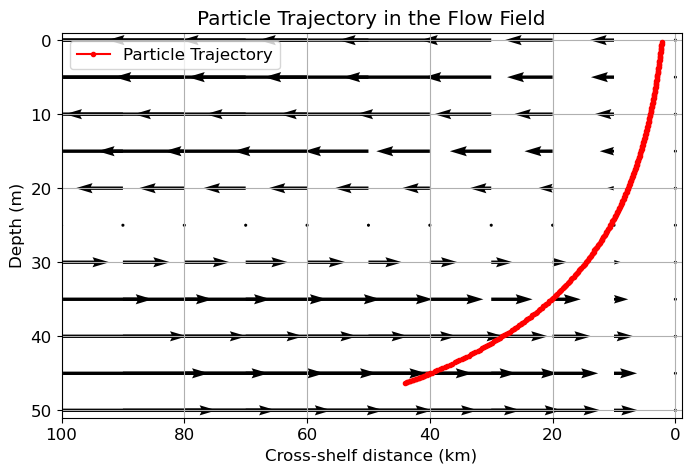

In [10]:
# Plot velocity field and one particle trajectory
plt.figure(figsize=(8, 5))
plt.quiver(X, Z, uvel, wvel, angles='xy', scale=200, color='black')
plt.plot(xp[0:i-1], zp[0:i-1], marker='.', color='red', label='Particle Trajectory')
plt.xlabel("Cross-shelf distance (km)")
plt.ylabel("Depth (m)")
plt.title('Particle Trajectory in the Flow Field')
plt.ylim(zlocation[0]-1, zlocation[-1]+1)
plt.xlim(xlocation[0]-1, xlocation[-1])
plt.gca().invert_xaxis()  # Reverse x-axis, assume it's west coast
plt.gca().invert_yaxis()

plt.grid(True)
plt.legend(loc='upper left')
plt.savefig(f'{fig_dir}/particle_Trajectory_01.png', bbox_inches='tight', dpi = 300)
plt.show()

In [11]:
# Save data to NetCDF
data = xr.Dataset(
    {
        "uvel": (("x", "z"), uvel),
        "wvel": (("x", "z"), wvel),
        "uvelL": ("time", uvelL),
        "wvelL": ("time", wvelL),
        "xp": ("time", xp),
        "zp": ("time", zp),
    },
    coords={
        "x": xlocation,
        "z": zlocation,
        "time": np.arange(ntime) * delt,
    },
)

data.to_netcdf(f'{out_dir}\Lagrangian_Model_velocity_particle_Case1.nc')

#### 2.3 Release an array of passive particles at an initial location of 20 km at 5 m intervals between depths of 10 to 45 m. track these particles for 20 days and plot their trajectories.

In [12]:
# Lagrangian Particle Tracking Parameters
days = 20
ntime = int(days * tconvert // delt)
print(f'Total number of time steps are: {int(ntime)}')
# Particle release settings
x0 = 20 * 1e5   # km to cm
z = 100 * np.arange(10, 50, 5)   # 5 m intervals between depths of 10 to 45 m. m to cm

n_particles = len(z)

# Initialize arrays for particle positions and velocities
xp = np.full((n_particles, ntime), x0)
zp = np.zeros((n_particles, ntime))

for n in range(n_particles):
    zp[n, 0] = z[n]

uvelL = np.zeros((n_particles, ntime))
wvelL = np.zeros((n_particles, ntime))

tinc = np.zeros((n_particles, ntime))
# Track particle trajectories
for n in range(n_particles):
    for i in range(1, ntime):
        tinc[n,i] = delt * i
        # calculate u component
        uaL = np.sin(np.pi * xp[n, i-1] / (2 * tlength))
        ubL = np.cos(np.pi * (zp[n, i-1] + z0) / tdepth)
        uvelL[n, i] = u0 * uaL * ubL
        
        # calculate w component
        waL = np.cos(np.pi * xp[n, i-1] / (2 * tlength))
        wbL = np.sin(np.pi * (zp[n, i-1]  + z0) / tdepth)
        wvelL[n, i] = wcons * u0 * waL * wbL

        # Update particle positions
        xp[n, i] = xp[n, i-1] + uvelL[n, i] * delt  # finite difference form 
        zp[n, i] = zp[n, i-1] + wvelL[n, i] * delt  # finite difference form 
        # Check for boundary conditions
        if xp[n, i] <= 0 or zp[n, i] < 0:
            print(f'Particle {n} reached boundary at step {i}, stop tracking')
            break

    print(f'Total tracking time for particle {n} is: {tinc[n, i] / tconvert:.1f} days')
# Convert particle locations to km and m
xp *= 0.00001  # Convert cm to km
zp *= 0.01  # Convert cm to m       

Total number of time steps are: 1152
Total tracking time for particle 0 is: 20.0 days
Total tracking time for particle 1 is: 20.0 days
Total tracking time for particle 2 is: 20.0 days
Total tracking time for particle 3 is: 20.0 days
Total tracking time for particle 4 is: 20.0 days
Total tracking time for particle 5 is: 20.0 days
Total tracking time for particle 6 is: 20.0 days
Total tracking time for particle 7 is: 20.0 days


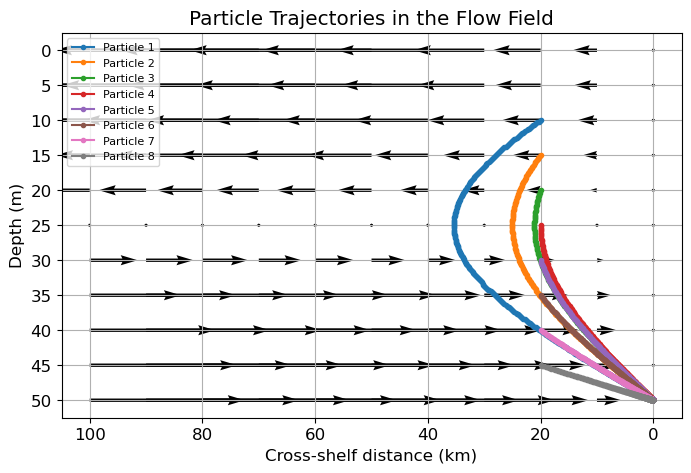

In [13]:
# Plot Particle Trajectories within the field
plt.figure(figsize=(8, 5))
plt.quiver(X, Z, uvel, wvel, angles='xy', scale=200, color='black')

for n in range(n_particles):
    plt.plot(xp[n, :], zp[n, :], marker='.', label=f'Particle {n+1}')

plt.xlabel("Cross-shelf distance (km)")
plt.ylabel("Depth (m)")
plt.yticks(np.arange(0, 51, 5))
plt.title('Particle Trajectories in the Flow Field')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend(loc='upper left', fontsize=8)
plt.savefig(f'{fig_dir}/particle_Trajectory_02.png', bbox_inches='tight', dpi=300)
plt.show()
